<a href="https://colab.research.google.com/github/SiyiTang/LearningProcess/blob/main/MyPortfolio%5B4%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
pip install deepdow

# Imports and Configuration

In [144]:
%matplotlib inline
from deepdow.benchmarks import Benchmark, OneOverN, Random, Singleton
from deepdow.callbacks import EarlyStoppingCallback, TensorBoardCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.experiments import Run
from deepdow.nn import KeynesNet
from deepdow.layers import (AttentionCollapse, AverageCollapse, CovarianceMatrix, Conv, NumericalMarkowitz, MultiplyByConstant,
                     RNN, SoftmaxAllocator, WeightNorm)
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import raw_to_Xy
import matplotlib.pyplot as plt
import numpy as np
import torch
import datetime
import pandas as pd
import pandas_datareader.data as web

# Initialize

In [145]:
# 获取默认图形尺寸
default_figsize = plt.rcParams["figure.figsize"]

In [146]:
# set random seed for repeatility
torch.manual_seed(4)
np.random.seed(5)

# Data Preprocess

In [147]:
# set start and end time
start = datetime.datetime(2010, 1, 1) 
end = datetime.datetime(2020, 12, 31)

# Which stocks to use: 京东方、格力电器、平安银行、长江电力
# tickers = ['000725.SZ', '000651.SZ', '000001.SZ','600900.SS']
tickers = ['AAPL','NFLX','AMZN','KO']
# fetch close price
raw_df = web.DataReader(tickers, 'yahoo', start=start, end=end)[['Close']]

In [148]:
# Re-structure the columns
raw_df.columns = pd.MultiIndex.from_product([tickers, ["Close"]], names=["Ticker", "Attribute"]
)
assert isinstance(raw_df, pd.DataFrame)
assert isinstance(raw_df.index, pd.DatetimeIndex)
assert isinstance(raw_df.columns, pd.MultiIndex)
raw_df.head()

Ticker,AAPL,NFLX,AMZN,KO
Attribute,Close,Close,Close,Close
Date,,,,
2010-01-04,7.643214,7.640000,133.899994,28.520000
2010-01-05,7.656429,7.358571,134.690002,28.174999
2010-01-06,7.534643,7.617143,132.250000,28.165001
2010-01-07,7.520714,7.485714,130.000000,28.094999
2010-01-08,7.570714,7.614286,133.520004,27.575001


Fill in with pandas-defined business days since that's used in DeepDow. Use ffill and bfill to copy the previous/next day's closing price assuming no change on days not provided from source.

Note: Chinese trading days are different than pandas business days

In [149]:
index = pd.date_range(start=raw_df.index[0], end=raw_df.index[-1], freq="B")

print(f"Num records before fill: {len(raw_df)}")
raw_df = pd.DataFrame(raw_df, index=index).ffill().bfill()
print(f"Num records after fill: {len(raw_df)}")

Num records before fill: 2769
Num records after fill: 2869


# Creat Database

Derive some parameters for use in creating datasets

In [150]:
n_timesteps = len(raw_df)
n_channels = len(raw_df.columns.levels[1])
n_assets = len(raw_df.columns.levels[0])

In [151]:
print('Timesteps = '+ str(n_timesteps))
print('Channels = '+ str(n_channels))
print('Assets = '+ str(n_assets))

Timesteps = 2869
Channels = 1
Assets = 4


In [152]:
lookback = 50  # Number of timesteps to look back, e.g. length of X in time
gap = 1  # Gap between end of X and start of y for each data sample
horizon = 5  # Number of timesteps to use for prediction

Generate the splits for train and test

In [153]:
X, timestamps, y, asset_names, indicators = raw_to_Xy(
    raw_df, lookback=lookback, gap=gap, freq="B", horizon=horizon
)

In [154]:
n_samples = n_timesteps - lookback - horizon - gap 
n_samples

2813

In [155]:
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:2249
Test range: 2305:2812


Convert `Xy` format to `InRAMDDataset` for loadin during training.

In [156]:
dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

X_sample, y_sample, timestamp_sample, asset_names = dataset[0]

Create a data loader for training from the dataset: 
* one for train
* one for test

In [178]:
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=64)

dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=64)

Print a sample to get acquainted with the format

In [179]:
X_batch, y_batch, timestamps_batch, asset_names_batch = next(iter(dataloader_test))
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")
print(f"Asset names: {asset_names_batch}")
print(f"Num Timestamps: {len(timestamps_batch)}, sample: {timestamps_batch[0]}")

X_batch shape: torch.Size([64, 1, 50, 4])
y_batch shape: torch.Size([64, 1, 5, 4])
Asset names: ['AAPL', 'AMZN', 'KO', 'NFLX']
Num Timestamps: 64, sample: 2019-09-03 00:00:00


In [180]:
loaders = {"train": dataloader_train, "test": dataloader_test}
date_ranges = {}
for label, d in loaders.items():
    minval = pd.Timestamp("2100-01-01 00:00:00", freq="B")
    maxval = pd.Timestamp("1970-01-01 00:00:00", freq="B")
    for _,_,c,_ in d:
        if min(c) < minval:
            minval = min(c)
        if max(c) > maxval:
            maxval = max(c)        
    date_ranges[label] = (minval, maxval)
    
print("Date ranges for each dataset:\n")
print(*[f"{k}: {v}\n" for k,v in date_ranges.items()])

Date ranges for each dataset:

train: (Timestamp('2010-03-15 00:00:00', freq='B'), Timestamp('2018-10-26 00:00:00', freq='B'))
 test: (Timestamp('2019-01-14 00:00:00', freq='B'), Timestamp('2020-12-23 00:00:00', freq='B'))



# Creat Network

In [181]:
network = KeynesNet(1,hidden_size=64)
print(network)

KeynesNet(
  (transform_layer): RNN(
    (cell): LSTM(1, 64)
  )
  (norm_layer_1): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (norm_layer_2): GroupNorm(4, 64, eps=1e-05, affine=True)
  (time_collapse_layer): AverageCollapse()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [182]:
network = network.train()

In [183]:
loss =SharpeRatio()

In [184]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test,
                  'train': dataloader_train,},
          optimizer=torch.optim.Adam(network.parameters(),lr=0.0001,amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss', dataloader_name='test', patience=20)
                  ])

## Train the network

In [185]:
history = run.launch(100)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch 14: 100%|██████████| 36/36 [00:27<00:00,  1.29it/s, loss=-0.17945, test_loss=-0.19611, train_loss=-0.17413]

Epoch 15: 100%|██████████| 36/36 [00:28<00:00,  1.28it/s, loss=-0.17593, test_loss=-0.19658, train_loss=-0.17629]

Epoch 16: 100%|██████████| 36/36 [00:28<00:00,  1.24it/s, loss=-0.17585, test_loss=-0.19639, train_loss=-0.17646]

Epoch 17: 100%|██████████| 36/36 [00:28<00:00,  1.24it/s, loss=-0.18342, test_loss=-0.19760, train_loss=-0.17709]

Epoch 18: 100%|██████████| 36/36 [00:29<00:00,  1.23it/s, loss=-0.17296, test_loss=-0.19838, train_loss=-0.17515]

Epoch 19: 100%|██████████| 36/36 [00:29<00:00,  1.24it/s, loss=-0.17603, test_loss=-0.19636, train_loss=-0.17664]

Epoch 20: 100%|██████████| 36/36 [00:28<00:00,  1.24it/s, loss=-0.18714, test_loss=-0.19933, train_loss=-0.17750]

Epoch 21: 100%|██████████| 36/36 [00:28<00:00,  1.25it/s, loss=-0.17819, test_loss=-0.19911, train_loss=-0.17810]

Epoch 22: 100%|██████████| 36/36 [00:29<00:00,  1.23i

Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [200]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

#print(per_epoch_results.count())  # 计算每个周期样本数量
print(per_epoch_results.mean())  # 计算每个epoch的平均loss

dataloader  metric  model    epoch
test        loss    network  0       -0.192018
                             1       -0.192171
                             2       -0.192283
                             3       -0.192391
                             4       -0.192473
                                        ...   
train       loss    network  75      -0.181239
                             76      -0.181448
                             77      -0.181442
                             78      -0.181589
                             79      -0.181645
Name: value, Length: 160, dtype: float64


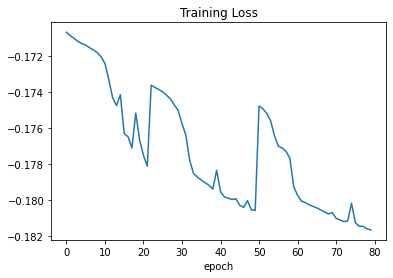

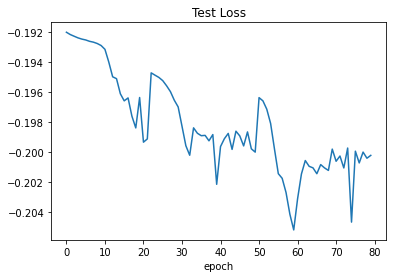

In [187]:
# Plot the training loss
plt.figure()
per_epoch_results.mean()["train"]["loss"]["network"].plot(title="Training Loss")

# Plot the test loss
plt.figure()
per_epoch_results.mean()["test"]["loss"]["network"].plot(title="Test Loss")
#per_epoch_results.mean()['test']['loss']['network'].plot()

In [188]:
network = network.eval()

In [189]:
# Assign benchmarks. Recall: IBM does poorly. Amazon does well.
# First add the individual stocks
benchmarks = {asset_name: Singleton(asset_ix=i) for i, asset_name in enumerate(asset_names_batch)}

# Now add the others
benchmarks["1overN"] = OneOverN()  # each asset has weight 1 / n_assets
benchmarks["random"] = Random()  # random allocation that is however close 1OverN
benchmarks["network"] = network  # our trained network

# Include metrics. Selected two, since using only one bombs out at time of writing
# NOTE: We are using `simple` here for the mean return, whereas most of the training and data config above is in log-space by default.
metrics = {
    "Sharpe": SharpeRatio(),
    "MeanReturn": MeanReturns(output_type="simple"),
    "MaxDD": MaximumDrawdown(),
}


In [190]:
metrics_table = generate_metrics_table(benchmarks, dataloader_test, metrics)

In [191]:
metrics_table['value'] *= -1

In [192]:
metrics_table.tail()

,timestamp,benchmark,metric,value
55,2019-12-11,network,MaxDD,-0.000167
56,2020-03-09,network,MaxDD,-0.118397
57,2020-03-27,network,MaxDD,-0.037690
58,2019-03-21,network,MaxDD,-0.007213
59,2019-08-26,network,MaxDD,-0.008461


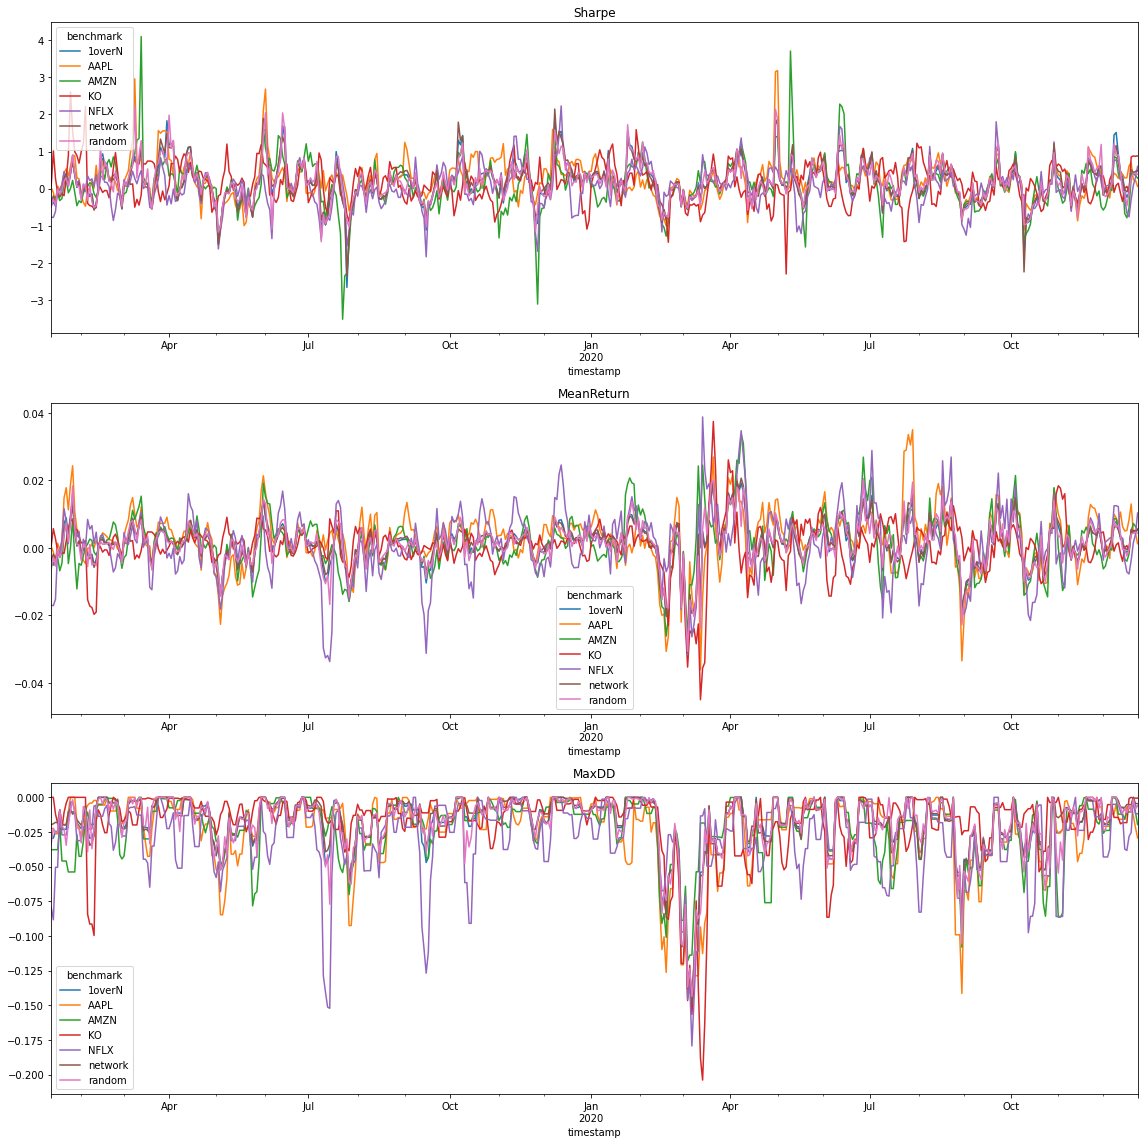

In [193]:
# Plot resulting metrics
# Note: this method doesn't accept a figure so we can't resize without assigning default figure size
plt.rcParams['figure.figsize'] = (16, 16)
plot_metrics(metrics_table)
plt.rcParams['figure.figsize'] = default_figsize

In [194]:
weight_table = generate_weights_table(network, dataloader_test)
weight_table

,AAPL,AMZN,KO,NFLX
2019-01-14,0.158109,0.253919,0.415797,0.172175
2019-01-15,0.158578,0.231668,0.431624,0.178130
2019-01-16,0.159538,0.216997,0.440301,0.183164
2019-01-17,0.159746,0.211103,0.440027,0.189125
2019-01-18,0.160713,0.217378,0.423580,0.198328
...,...,...,...,...
2020-12-17,0.256550,0.193587,0.369963,0.179899
2020-12-18,0.256630,0.192870,0.366561,0.183940
2020-12-21,0.250948,0.194256,0.364351,0.190445
2020-12-22,0.255037,0.191084,0.366236,0.187643


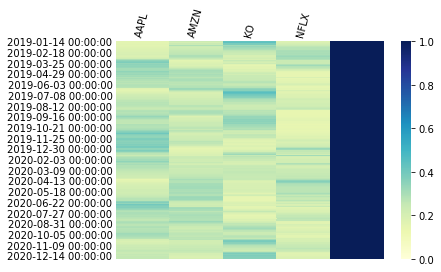

In [195]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [196]:
benchmark_num = metrics_table['benchmark'].unique()
metric_num = metrics_table['metric'].unique()

In [197]:
df2=pd.DataFrame(np.random.randn(len(benchmark_num),len(metric_num)),
                 index=list(benchmark_num),
                 columns=list(metric_num))
for i in benchmark_num:
  for j in metric_num:
    returns = metrics_table.query(f"(metric=='{j}') & (benchmark == '{i}')")
    index_num=list(benchmark_num).index(i)
    column_num=list(metric_num).index(j)
    df2.iloc[index_num][column_num]=returns['value'].mean()
    #print(index_num,column_num,returns['value'].mean())
print(df2)




           Sharpe  MeanReturn     MaxDD
AAPL     0.238337    0.002707 -0.022453
AMZN     0.114759    0.001489 -0.022167
KO       0.130506    0.000412 -0.018429
NFLX     0.062595    0.001124 -0.029963
1overN   0.192418    0.001427 -0.017555
random   0.193247    0.001407 -0.018391
network  0.200207    0.001513 -0.017136
